In [1]:
!pip install -r requirements.txt

In [25]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import stft

from loading_data import *
from CONSTANT import *


In [ ]:
def number_fft(window_size):
    power = 0
    window_tmp = window_size - 1
    while(window_tmp != 1):
        power = power + 1
        window_tmp = int(window_tmp / 2)
    return pow(2,power +1)

def feature_extraction(input_data, stft_parameters=DEFAULT_STFT_PARAMETERS, label_num=0, fs=SAMPLING_FQ):
    '''
    @brief This function use to extract the feature for one trial.

    @param 1 input_data: data read from '.mat' files, type np.ndarray
    @param 2 use_channel_inds: indicates of channels you need amount 14 channels. type list
    @param 3 window_size: length of segment to do stft and to smooth the specturm in unit second, type integer
    @param 4 window_shift: length of window sliding DFT, type integer
    @param 5 data_time: length of time about trials, type integer, default 40
    @param 6 FS: sampling frequency, type integer, default 128

    @return features extracted in format np.array, labels in format list

    '''
    def square(x): return (np.abs(x))**2
    def decibels(x): return 10*np.log10(x)
    window_size = stft_parameters['window_size']
    window_shift = stft_parameters['window_shift']
    avg_window_size = stft_parameters['avg_filter_size']
    window_type = stft_parameters['window_type']

    times = fs / window_shift
    feature_list = []

    nfft_size = number_fft(window_size)

    for i in range(62): # channels num

        channel_feature_list = []
        eeg_feq = stft(input_data[:, i], fs, window_type, nperseg=window_size*fs,
                       noverlap=window_size*fs-window_shift, nfft=nfft_size*fs)
#         eeg_feq = stft(input_data[:,i], fs, nperseg=2*fs, noverlap=None)
        eeg_feq_data = eeg_feq[-1]
        eeg_feq_data = eeg_feq_data[0:-1, 0:-1]
        eeg_feq_data = eeg_feq_data.reshape(128, int(nfft_size/2), -1)

        for j in range(1,62):    # frequency check
            current = eeg_feq_data[j+1, :, :].mean(axis=0)
            current = np.apply_along_axis(square, axis=0, arr=current)
            current = np.apply_along_axis(decibels, axis=0, arr=current)
            feature = moving_average_smooth(current, avg_window_size)
            channel_feature_list.append(feature)
        channel_feature_list = standardscaler_dataframe_train(
            np.array(channel_feature_list))
        if (i == 0):
            feature_list = np.array(channel_feature_list)
        else:
            feature_list = np.vstack(
                (feature_list, np.array(channel_feature_list)))
            
    # focused : 0   - > unfocused : 1 drowsed : 2
    label = [label_num]* feature_list.shape[1]
    return feature_list.transpose(), label


def moving_average_smooth(interval, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    re = np.convolve(interval, window, 'same')
    return re


def standardscaler_dataframe_train(feature_list):
    scaler_list = list()
    new_feature_list = list()
    for i in range(len(feature_list)):
        scaler = StandardScaler()
        x = np.array(feature_list[i]).reshape(-1, 1)
        x = scaler.fit_transform(x)
        # print(x.reshape(-1).shape)
        new_feature_list.append(x.reshape(-1))
        scaler_list.append(scaler)

    return new_feature_list

def set_seed(seed=42):
    '''
    set all random seed to 42
    '''
    random.seed(seed)  # python
    np.random.seed(seed)  # numpy
#     torch.manual_seed(seed) # pytorch
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False


set_seed(1)



In [27]:
def process_dataset_to_fold(label_choices=[0,3]):
    X_train_folds = []
    X_test_folds = []
    y_train_folds = []
    y_test_folds = []

    for session_except in [1,2,3]:
        X_train = []
        y_train = []
        list_session = [1,2,3]
        list_session.remove(session_except)
        for session_num in list_session:
            for file_num in range (24):
                label_list = SESSION_LABELS[str(session_num)]
                x_part, y_part = feature_extraction(input_data=d[str(session_num)][str(file_num)], label_num=label_list[file_num])
                if label_list[file_num] in label_choices:
                    X_train.extend(list(x_part))
                    y_train.extend(list(y_part))

        X_test = []
        y_test = []
        for file_num in range (24):
            label_list = SESSION_LABELS[str(session_except)]
            x_part, y_part = feature_extraction(input_data=d[str(session_except)][str(file_num)], label_num=label_list[file_num])
            if label_list[file_num] in label_choices:
                X_test.extend(list(x_part))
                y_test.extend(list(y_part))

        X_train_folds.append(X_train)
        X_test_folds.append(X_test)
        y_train_folds.append(y_train)
        y_test_folds.append(y_test)
    return X_train_folds, X_test_folds, y_train_folds, y_test_folds


In [28]:
def logistic_regression_train_and_test(X_train, y_train, X_test, y_test, print_check=True):
    if not isinstance(X_train, np.ndarray):
        X_train = np.array(X_train)
    if not isinstance(X_test, np.ndarray):
        X_test = np.array(X_test)
    if not isinstance(y_train, np.ndarray):
        y_train = np.array(y_train)
    if not isinstance(y_test, np.ndarray):
        y_test = np.array(y_test)

    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)

    class_weights = dict(zip(classes, weights))

    # 2. Tạo pipeline gồm chuẩn hoá + mô hình SVM (RBF kernel)
    model = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42, class_weight=class_weights)

    # 3. Train
    model.fit(X_train, y_train)

    # 4. Dự đoán
    y_pred = model.predict(X_test)

    # 5. Đánh giá   
    acc = accuracy_score(y_test, y_pred)
    if print_check:
        print('Logistic Regression training:')
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])

        # Plot the confusion matrix
        disp.plot(cmap=plt.cm.Blues) # You can choose different colormaps
        plt.title("Confusion Matrix Logistic Regression")
        plt.show()
        print("Test Accuracy:", acc)

        print("\nClassification report:")
        print(classification_report(y_test, y_pred, zero_division=0))
    return model, acc

def support_vector_machine_train_and_test(X_train, y_train, X_test, y_test, print_check=True):
    if not isinstance(X_train, np.ndarray):
        X_train = np.array(X_train)
    if not isinstance(X_test, np.ndarray):
        X_test = np.array(X_test)
    if not isinstance(y_train, np.ndarray):
        y_train = np.array(y_train)
    if not isinstance(y_test, np.ndarray):
        y_test = np.array(y_test)

    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)

    class_weights = dict(zip(classes, weights))

    # 2. Tạo pipeline gồm chuẩn hoá + mô hình SVM (RBF kernel)
    model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, class_weight=class_weights)

    # 3. Train
    model.fit(X_train, y_train)

    # 4. Dự đoán
    y_pred = model.predict(X_test)

    # 5. Đánh giá   
    acc = accuracy_score(y_test, y_pred)
    if print_check:
        print('\nSupport Vector Machine training:')
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])

        # Plot the confusion matrix
        disp.plot(cmap=plt.cm.Blues) # You can choose different colormaps
        plt.title("Confusion Matrix Support Vector Machine")
        plt.show()
        print("Test Accuracy:", acc)

        print("\nClassification report:")
        print(classification_report(y_test, y_pred))
    return model, acc

def random_forest_train_and_test(X_train, y_train, X_test, y_test, n_estimators=100, print_check=True):
    if not isinstance(X_train, np.ndarray):
        X_train = np.array(X_train)
    if not isinstance(X_test, np.ndarray):
        X_test = np.array(X_test)
    if not isinstance(y_train, np.ndarray):
        y_train = np.array(y_train)
    if not isinstance(y_test, np.ndarray):
        y_test = np.array(y_test)

    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)

    class_weights = dict(zip(classes, weights))
    y_train = np.array(y_train).reshape([-1, 1])
    y_test = np.array(y_test).reshape([-1, 1])

    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42, class_weight=class_weights)

    # Train
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    if print_check:
        print('\n\nRandom Forest training:')
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])

        # Plot the confusion matrix
        disp.plot(cmap=plt.cm.Blues) # You can choose different colormaps
        plt.title("Confusion Matrix Random Forest")
        plt.show()
        print("Test Accuracy:", acc)

        # Detailed report
        print("\nClassification report:")
        print(classification_report(y_test, y_pred))
    return rf, acc

Logistic Regression training:


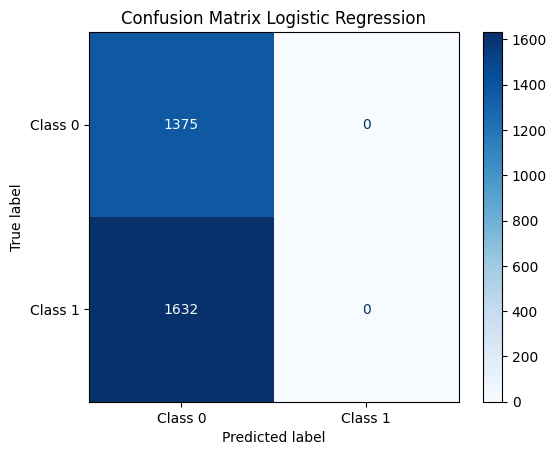

Test Accuracy: 0.4572663784502827

Classification report:
              precision    recall  f1-score   support

           0       0.46      1.00      0.63      1375
           1       0.00      0.00      0.00      1632

    accuracy                           0.46      3007
   macro avg       0.23      0.50      0.31      3007
weighted avg       0.21      0.46      0.29      3007

Logistic Regression training:


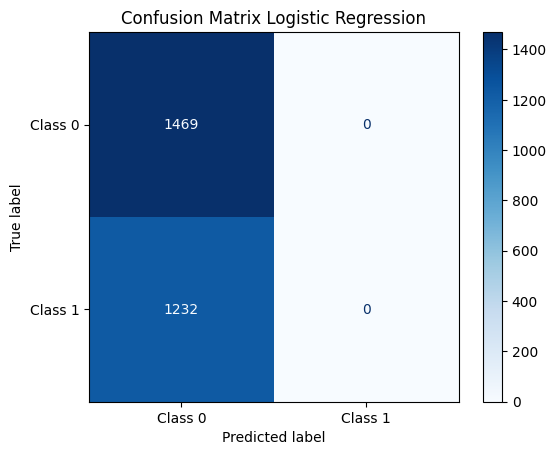

Test Accuracy: 0.5438726397630507

Classification report:
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      1469
           1       0.00      0.00      0.00      1232

    accuracy                           0.54      2701
   macro avg       0.27      0.50      0.35      2701
weighted avg       0.30      0.54      0.38      2701

Logistic Regression training:


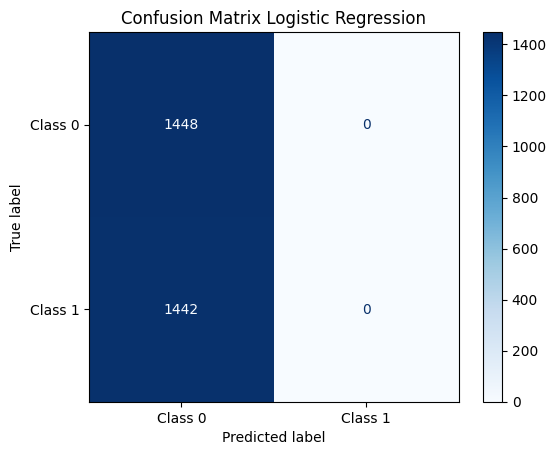

Test Accuracy: 0.501038062283737

Classification report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1448
           1       0.00      0.00      0.00      1442

    accuracy                           0.50      2890
   macro avg       0.25      0.50      0.33      2890
weighted avg       0.25      0.50      0.33      2890


Support Vector Machine training:


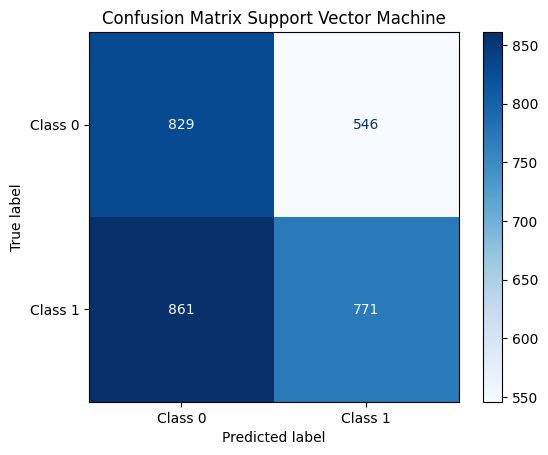

Test Accuracy: 0.5320917858330562

Classification report:
              precision    recall  f1-score   support

           0       0.49      0.60      0.54      1375
           1       0.59      0.47      0.52      1632

    accuracy                           0.53      3007
   macro avg       0.54      0.54      0.53      3007
weighted avg       0.54      0.53      0.53      3007


Support Vector Machine training:


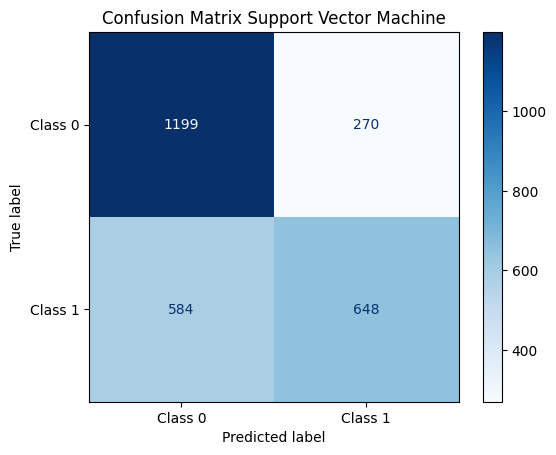

Test Accuracy: 0.6838208071084784

Classification report:
              precision    recall  f1-score   support

           0       0.67      0.82      0.74      1469
           1       0.71      0.53      0.60      1232

    accuracy                           0.68      2701
   macro avg       0.69      0.67      0.67      2701
weighted avg       0.69      0.68      0.68      2701


Support Vector Machine training:


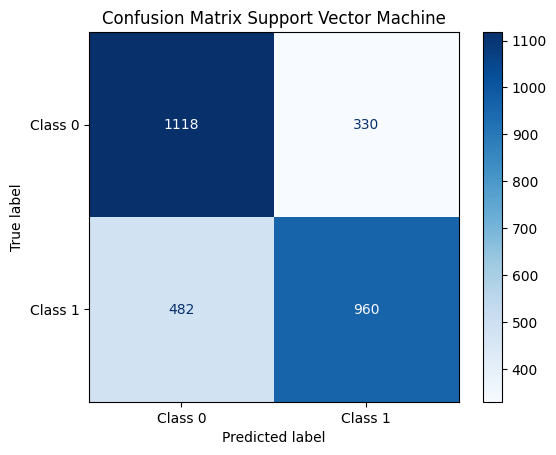

Test Accuracy: 0.7190311418685121

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.77      0.73      1448
           1       0.74      0.67      0.70      1442

    accuracy                           0.72      2890
   macro avg       0.72      0.72      0.72      2890
weighted avg       0.72      0.72      0.72      2890



/Users/dungna/Documents/Code project/python/Code earable/c_Kimi/.kenv/lib/python3.12/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)




Random Forest training:


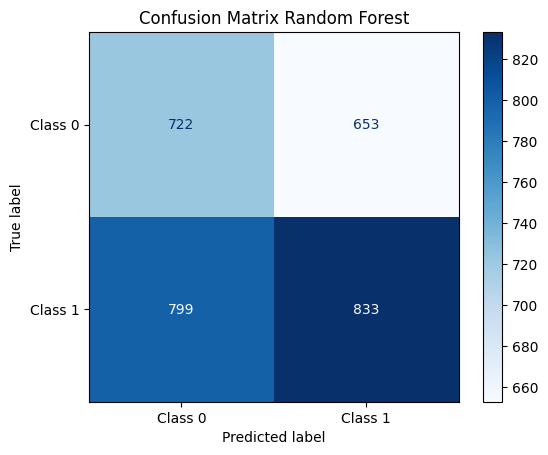

Test Accuracy: 0.5171267043565015

Classification report:
              precision    recall  f1-score   support

           0       0.47      0.53      0.50      1375
           1       0.56      0.51      0.53      1632

    accuracy                           0.52      3007
   macro avg       0.52      0.52      0.52      3007
weighted avg       0.52      0.52      0.52      3007



/Users/dungna/Documents/Code project/python/Code earable/c_Kimi/.kenv/lib/python3.12/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)




Random Forest training:


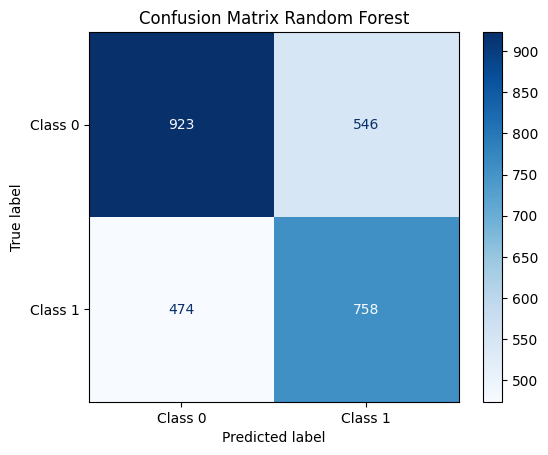

Test Accuracy: 0.6223620881155127

Classification report:
              precision    recall  f1-score   support

           0       0.66      0.63      0.64      1469
           1       0.58      0.62      0.60      1232

    accuracy                           0.62      2701
   macro avg       0.62      0.62      0.62      2701
weighted avg       0.62      0.62      0.62      2701



/Users/dungna/Documents/Code project/python/Code earable/c_Kimi/.kenv/lib/python3.12/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)




Random Forest training:


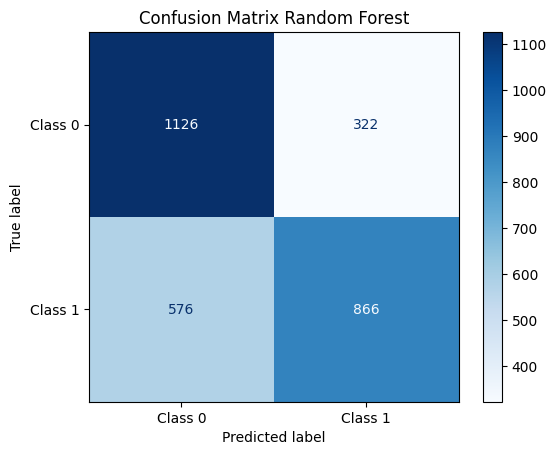

Test Accuracy: 0.6892733564013841

Classification report:
              precision    recall  f1-score   support

           0       0.66      0.78      0.71      1448
           1       0.73      0.60      0.66      1442

    accuracy                           0.69      2890
   macro avg       0.70      0.69      0.69      2890
weighted avg       0.70      0.69      0.69      2890

Mean accuracy on cross validation for Logistic Regression learning: 50.07%
Mean accuracy on cross validation for Support Vector Machine learning: 64.50%
Mean accuracy on cross validation for Random Forest learning: 60.96%


In [29]:
X_train_folds, X_test_folds, y_train_folds, y_test_folds = process_dataset_to_fold(label_choices=[0,1])

acc_LR_summarize = []
acc_SVM_summarize = []
acc_RF_summarize = []

PRINT_CHECK = True
for i in range (3):
    modelLR, accLR = logistic_regression_train_and_test(X_train=X_train_folds[i], y_train=y_train_folds[i], X_test=X_test_folds[i], y_test=y_test_folds[i], print_check=PRINT_CHECK)
    acc_LR_summarize.append(accLR)

for i in range (3):
    modelSVM, accSVM = support_vector_machine_train_and_test(X_train=X_train_folds[i], y_train=y_train_folds[i], X_test=X_test_folds[i], y_test=y_test_folds[i], print_check=PRINT_CHECK)
    acc_SVM_summarize.append(accSVM)

for i in range (3):
    modelRF, accRF = random_forest_train_and_test(X_train=X_train_folds[i], y_train=y_train_folds[i], X_test=X_test_folds[i], y_test=y_test_folds[i], n_estimators=200, print_check=PRINT_CHECK)
    acc_RF_summarize.append(accRF)


print(f'Mean accuracy on cross validation for Logistic Regression learning: {np.mean(np.array(acc_LR_summarize))*100:.2f}%')
print(f'Mean accuracy on cross validation for Support Vector Machine learning: {np.mean(np.array(acc_SVM_summarize))*100:.2f}%')
print(f'Mean accuracy on cross validation for Random Forest learning: {np.mean(np.array(acc_RF_summarize))*100:.2f}%')